In [2]:
%matplotlib widget

In [15]:
import numpy as np
import matplotlib.pyplot as plt

import utils
import config

In [4]:
fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
    url = ["https://osf.io/agvxh/download"]
    url.append("https://osf.io/uv3mw/download")
    url.append("https://osf.io/ehmw2/download")

In [5]:
data=utils.load_data(fname)

In [ ]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in config.BRAIN_GROUPS:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(data)), dtype=bool)
for j, d in enumerate(data):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in config.BRAIN_GROUPS:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(data)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(config.BRAIN_GROUPS, config.REGION_COLORS):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

In [7]:
data[18]['spks'].shape # number of neurons by number of trials by time bins of 10 ms

(606, 247, 250)

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


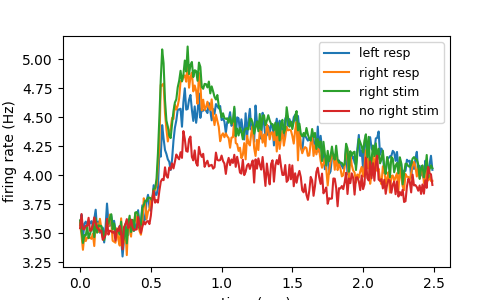

In [20]:
# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = data[11]
print(dat.keys())

dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape[-1]

fig,ax = plt.subplots(figsize=(5, 3))
response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response > 0].mean(axis=(0, 1)))  # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response < 0].mean(axis=(0, 1)))  # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right > 0].mean(axis=(0, 1)))  # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right == 0].mean(axis=(0, 1)))  # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=9)
ax.set(xlabel='time (sec)', ylabel='firing rate (Hz)')
plt.show()

In [9]:
np.unique(dat['brain_area'])

array(['ACA', 'CA1', 'DG', 'LGd', 'LH', 'MD', 'MOs', 'PL', 'SUB', 'VISam',
       'VISp', 'root'], dtype='<U5')

In [18]:
nareas = 4  # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area'])  # number of neurons
barea = nareas * np.ones(NN, )  # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], config.BRAIN_GROUPS[j])] = j  # assign a number to each region

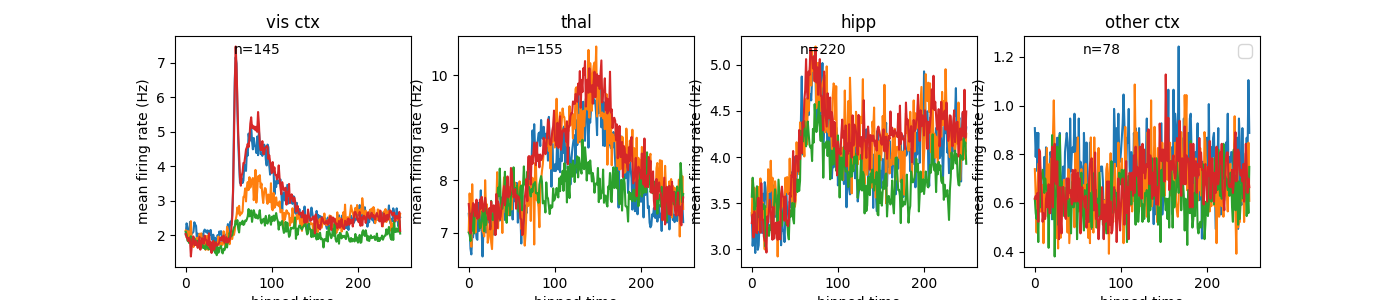

In [38]:
fig,ax = plt.subplots(nrows=1, ncols=nareas,figsize=(14,3))
for j in range(nareas):
  

  ax[j].plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right > 0)].mean(axis=(0, 1)))
  ax[j].plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right == 0)].mean(axis=(0, 1)))
  ax[j].plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right == 0)].mean(axis=(0, 1)))
  ax[j].plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right > 0)].mean(axis=(0, 1)))
  ax[j].text(.25, .92, 'n=%d'%np.sum(barea == j), transform=ax[j].transAxes)
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax[j].set(xlabel='binned time', ylabel='mean firing rate (Hz)', title=config.REGIONS[j])

plt.show()

In [48]:
i_correct_ch =np.where(dat['feedback_type']==1)[0]

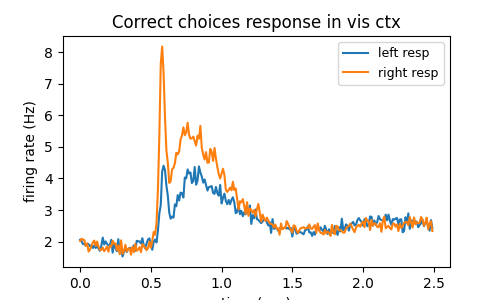

In [98]:
region= 0 
dat_correct = dat['spks'][:, i_correct_ch]

dat_correct_left = dat_correct[barea==region][:, response[i_correct_ch] > 0]  # left responses
dat_correct_right = dat_correct[barea==region][:, response[i_correct_ch] < 0]  # right responses


fig,ax = plt.subplots(figsize=(5, 3))

plt.plot(dt * np.arange(NT), 1/dt * dat_correct_left.mean(axis=(0, 1)))  # mean across neurons (axis 0) and trials (axis 1)
plt.plot(dt * np.arange(NT), 1/dt * dat_correct_right.mean(axis=(0, 1))) 
plt.legend(['left resp', 'right resp'], fontsize=9)
ax.set(xlabel='time (sec)', ylabel='firing rate (Hz)',title="Correct choices response in %s"%config.REGIONS[region])
plt.show()